# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Признаки
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **NotRepaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

Целевой признак
* **Price** — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обработка пропусков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обработка-аномальных-значений" data-toc-modified-id="Обработка-аномальных-значений-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обработка аномальных значений</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Отбор-признаков" data-toc-modified-id="Отбор-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Отбор признаков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-7"><span class="toc-item-num">7&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Загрузка данных

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import catboost as cbt
import lightgbm as lgb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

Инициализируем глобальные константы.

In [2]:
RANDOM_STATE = 17

NEG_RMSE = 'neg_root_mean_squared_error'
RMSE = 'root_mean_squared_error'

Загрузим данные и выведем первые пять строк.

In [3]:
autos_df = pd.read_csv('autos.csv', sep=None, engine='python')
autos_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные загружены корректно.

Посмотрим, какие типы данных были определены и есть ли пропуски в данных.

In [4]:
autos_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные представляют собой таблицу из 354368 строк и 16 столбцов-признаков.  
Датам и категориальным признакам присвоены типы 'object', оставшиеся 7 имеют целочисленный тип.  
Заметно, что часть данных пропущена.

Проанализируем пропуски.

      Столбец          Пропусков, %   Всего пропусков
VehicleType               10.579          37490     
Gearbox                   5.597           19833     
Model                     5.561           19705     
FuelType                  9.283           32895     
NotRepaired               20.079          71154     



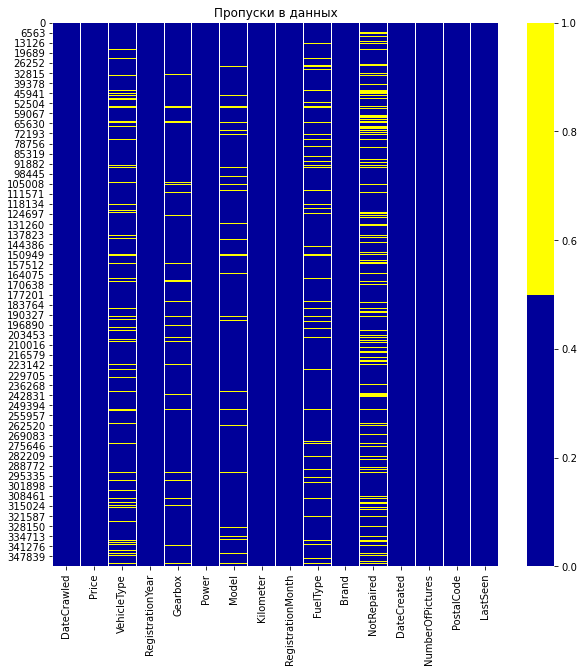

In [5]:
def visualize_df_nulls(df: pd.DataFrame):
    """
    Функция отображает процент пропусков и их число, а также визуализирует их.
    
    Аргументы
    ---------
    df : pd.DataFrame
        Датафрейм, по которому выводится информация о пропусках.
        
    Возвращает
    ----------
    None
    
    """
    colours = ['#000099', '#ffff00']
    plt.figure(figsize=(10, 10))
    sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))
    try:
        ttl = df.name + ' nulls'
    except:
        ttl = 'Пропуски в данных'

    plt.title(ttl)
    print('{:^20}{:^18}{:^14}'.format('Столбец', 'Пропусков, %', 'Всего пропусков'))
    for col in df.columns:
        missed_data_share = df[col].isnull().mean() * 100
        missed_data_count = df[col].isnull().sum()
        if missed_data_count > 0:
            print('{:<20}{:^18.3f}{:^14}'.format(col, missed_data_share, missed_data_count))


visualize_df_nulls(autos_df)
print()

Данные пропущены в следующих признаках:
* VehicleType - 10.6%
* Gearbox - 5.6%
* Model - 5.6%
* FuelType - 9.3%
* NotRepaired - 20.1%

Пропусков достаточно много и целесообразнее попытаться их заменить, чем просто удалить.

Выведем статистическую информацию о данных.

DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-16 17:43:49    5
2016-03-21 14:50:20    5
                      ..
2016-03-20 09:46:29    1
2016-03-26 21:54:00    1
2016-03-14 14:55:12    1
2016-03-10 19:52:23    1
2016-04-04 22:42:10    1
Name: DateCrawled, Length: 271174, dtype: int64

Price
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


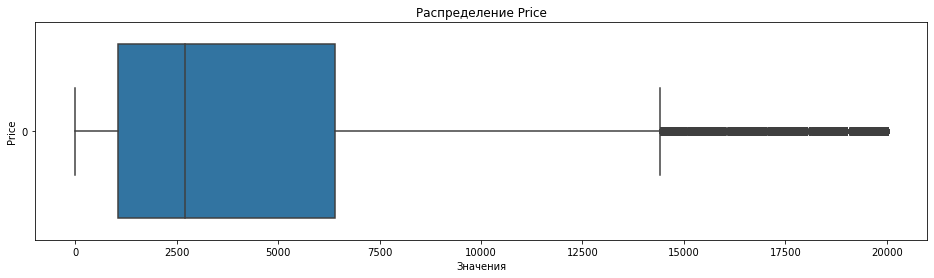

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

RegistrationYear
count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


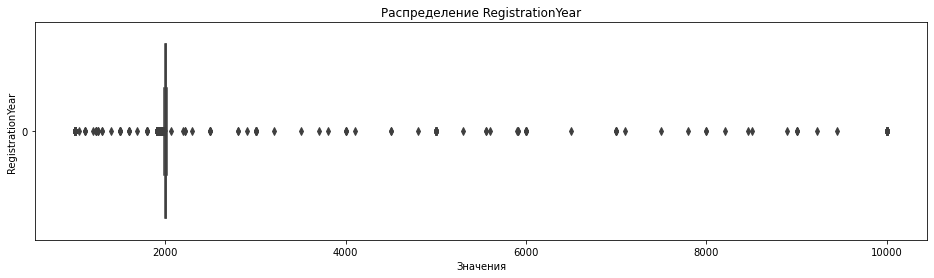

Gearbox
['manual' 'auto' nan]
manual    268251
auto       66285
Name: Gearbox, dtype: int64

Power
count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


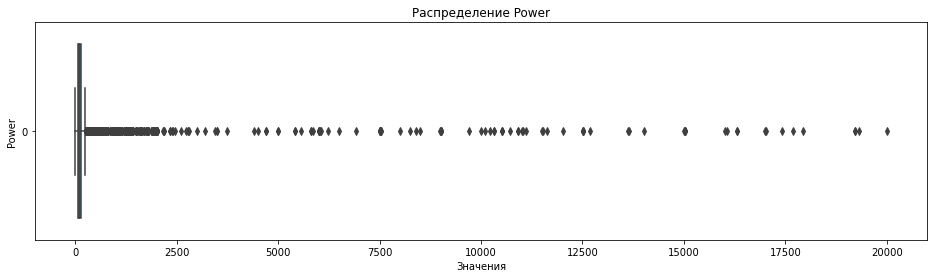

Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leo

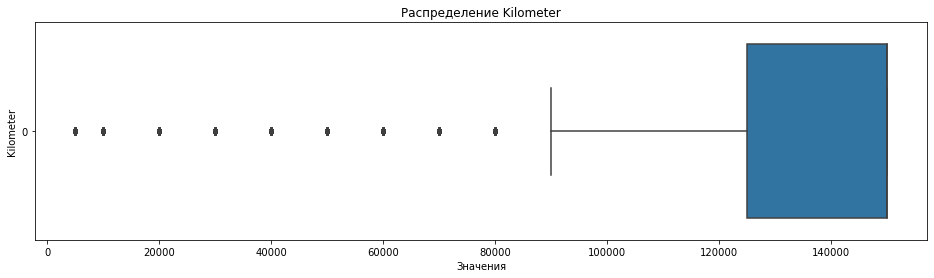

RegistrationMonth
count    354369.000000
mean          5.714645
std           3.726421
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64


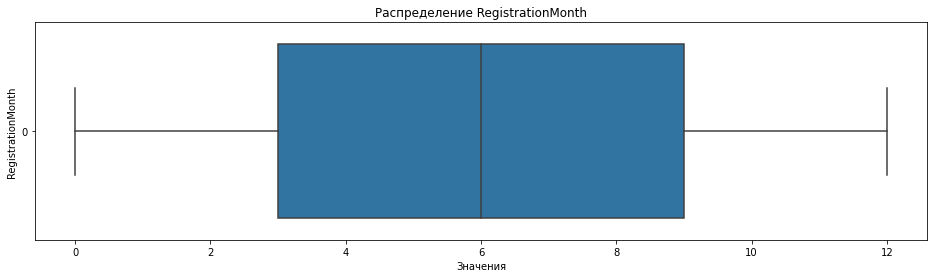

FuelType
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Brand
['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota          

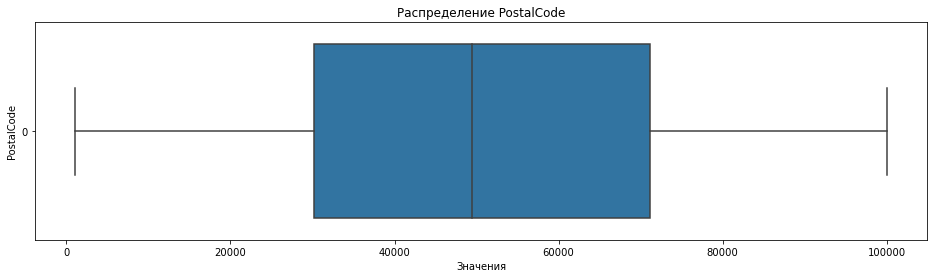

LastSeen
['2016-04-07 03:16:57' '2016-04-07 01:46:50' '2016-04-05 12:47:46' ...
 '2016-03-19 20:44:43' '2016-03-29 10:17:23' '2016-03-21 10:42:49']
2016-04-06 13:45:54    17
2016-04-07 09:44:27    16
2016-04-07 09:45:10    16
2016-04-07 13:17:48    16
2016-04-06 09:46:00    16
                       ..
2016-03-24 13:45:11     1
2016-04-03 00:45:14     1
2016-03-17 19:49:50     1
2016-03-17 17:46:55     1
2016-03-19 18:47:47     1
Name: LastSeen, Length: 179150, dtype: int64



In [6]:
def info(data: pd.DataFrame):
    """
    Функция пробегает по признакам датафрейма и, если тип у признака object,
    выводит уникальные значения и их количество, в противном случае 
    оценивается распределение.
    
    Аргументы
    ---------
    data : pd.DataFrame
        Датафрейм, по которому выводится информация.
        
    Возвращает
    ----------
    None
    
    """
    for column in data.columns:
        if data[column].dtype == 'object':
            print(column)
            print(data[column].unique())
            print(data[column].value_counts())
            print()
        else:
            print(column)
            print(data[column].describe())
            # Если число уникальных значений в столбце между 1 и длиной столбца, то вывести распределение признака
            if len(data[column].unique()) > 1 and len(data[column].unique()) != len(data[column]):
                plt.figure(figsize=(16, 4))
                sns.boxplot(data=data[column], orient='h')
                plt.xlabel('Значения')
                plt.ylabel(column)
                plt.title('Распределение ' + column)
                plt.show()
                
info(autos_df)

По распределениям количественных признаков заметны некоторые особенности:
* в столбце **'Price'** есть нулевые значения, т.е. автомобили отдаются даром;
* в столбце **'RegistrationYear'** есть нереальные значения лет регистрации: как в сторону прошлого, так и в сторону будущего;
* в столбце **'Power'** есть нереальные значения мощности автомобиля (например, больше 2500), а очень малые значения, в т.ч. нулевые (возможно, автомобиль продаётся без двигателя на запчасти);
* в столбце **'RegistrationMonth'** 13 значений месяца регистрации, хотя в реальности всего 12 месяцев, при этом значения распределены равномерно, так как 25% хвосты по длине совпадают с 25%-50% и с 50%-75% распределения;
* признак **'NumberOfPictures'** неинформативен, так как все значения равны нулю.

### Вывод

* Данные представляют собой таблицу из 354368 строк и 16 столбцов-признаков.
* Датам и категориальным признакам присвоены типы 'object', оставшиеся 7 признаков имеют целочисленный тип.
* Данные пропущены в следующих признаках:
    * VehicleType - 10.6%
    * Gearbox - 5.6%
    * Model - 5.6%
    * FuelType - 9.3%
    * NotRepaired - 20.1%
* Пропусков достаточно много и поэтому целесообразнее попытаться их заменить, чем просто удалить.
* Статистический анализ данных показал, что:
    * в столбце **'Price'** есть нулевые значения, т.е. автомобили отдаются даром;
    * в столбце **'RegistrationYear'** есть нереальные значения лет регистрации: как в сторону прошлого, так и в сторону будущего;
    * в столбце **'Power'** есть нереальные значения мощности автомобиля (например, больше 2500), а очень малые значения, в т.ч. нулевые (возможно, автомобиль продаётся без двигателя на запчасти);
    * в столбце **'RegistrationMonth'** 13 значений месяца регистрации, хотя в реальности всего 12 месяцев, при этом значения распределены равномерно, так как 25% хвосты по длине совпадают с 25%-50% и с 50%-75% распределения;
    * признак **'NumberOfPictures'** неинформативен, так как все значения равны нулю.

## Обработка пропусков

Пропуски будем заменять в соотвествии со следующей стратегией:
* **Model**: Nan => 'unknown'
* **VehicleType**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
* **GearBox**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
* **FuelType**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
* **NotRepaired**: Nan => 'unknown'

Заполним пропуски в столбце **'Model'** и проверим корректность процедуры.

In [7]:
autos_df['Model'].fillna('unknown', inplace=True)
autos_df['Model'].isnull().sum()

0

Напишем функцию для замены пропусков на необходимую статистику, вычисленную внутри некоторой группы (среза датафрейма).

In [8]:
def fillna_using_filter(df: pd.DataFrame, col_to_fill: str, cols_to_filter: list, fill_with: str):
    """
    Заполняет пропуски в столбце датафрейма значениями, полученными на основе отфильтрованных с помощью столбцов-фильтров:
    для каждого пропуска ищутся строки датафрейма, в которых содержатся значения, равные тем, что находятся в той же строке
    в столбцах-фильтрах, и считается некоторый параметр (например, среднее) по отфильтрованному целевому столбцу.
    
    Аргументы
    ---------
    df : pd.DataFrame
        Исходный датафрейм.
    col_to_fill : str
        Имя столбца, в котором необходимо заполнить пропуски.
    cols_to_filter : list
        Список имён столбцов, значения которых используются для фильтрации данных.
    fill_with : {'mean', 'median', 'mode'}
        Название статистики, рассчитываемой по целевому столбцу.
        
    Возвращает
    ----------
    None
    
    """
    def get_selected_statistic(series: pd.Series):
        """
        По названию метода получает значение соответствующей статистики (среднего, медианы или моды)
        для последовательности pd.Series.
        
        Аргументы
        ---------
        series : pd.Series
            Столбец датафрейма, для которого считается статистика.
        
        Возвращает
        ----------
        Значение статистики.
        
        """
        func_dict = {
            'mean': series.mean,
            'median': series.median,
            'mode': series.mode
        }
        
        try:
            value = func_dict[fill_with]()
            if type(value) == pd.Series:
                value = value.values[0]
                
            return value
        except KeyError:
            print('Ошибка: неверное значение аргумента fill_with')
            return np.nan
    
    try:
        indices = df[df[col_to_fill].isnull()].index
    except KeyError:
        print('Ошибка: в датафрейме нет столбца с именем "{}"'.format(col_to_fill))
        return
    
    new_values = []
    stop = len(indices)
    
    print('Прогресс: 0%', end='\r')
    for j, index in enumerate(indices):
        try:
            query_list = [
                col + '==' + str(df.loc[index, col])
                if df[col].dtype != 'O'
                else col + '=="' + df.loc[index, col] + '"'
                for col in cols_to_filter
            ]
        except KeyError as e:
            if 'None of' in e.args[0]:
                print(e.args[0])
                return
            else:
                print('Ошибка: в датафрейме нет столбца с именем "{}"'.format(e.args[0]))
                return

        query_text = ' and '.join(query_list)

        new_value = get_selected_statistic(df.query(query_text)[col_to_fill])
        new_values.append(new_value)
            
        print('Прогресс: {:.2%}'.format((j + 1) / stop), end='\r')
            
    if not indices.empty:
        df.loc[indices, col_to_fill] = new_values
    print('В столбце "{}" осталось {} пропущенных значений.'.format(col_to_fill, df[col_to_fill].isnull().sum()))

Заполним пропуски в столбце **'VehicleType'** и выведем изменения по каждой категории.

In [9]:
%%time
old_value_counts = autos_df['VehicleType'].value_counts()
fillna_using_filter(df=autos_df, col_to_fill='VehicleType', cols_to_filter=['Model', 'Brand'], fill_with='mode')

В столбце "VehicleType" осталось 0 пропущенных значений.
Wall time: 21min 21s


In [178]:
autos_df['VehicleType'].value_counts() - old_value_counts

sedan          15721
small          12738
wagon           3642
bus             3759
convertible      272
coupe            649
suv              684
other             25
Name: VehicleType, dtype: int64

Заполним пропуски в столбце **'Gearbox'** и выведем изменения по каждой категории.

In [11]:
%%time
old_value_counts = autos_df['Gearbox'].value_counts()
fillna_using_filter(df=autos_df, col_to_fill='Gearbox', cols_to_filter=['Model', 'Brand'], fill_with='mode')

В столбце "Gearbox" осталось 0 пропущенных значений.
Wall time: 11min 23s


In [181]:
autos_df['Gearbox'].value_counts() - old_value_counts

manual    17800
auto       2033
Name: Gearbox, dtype: int64

Заполним пропуски в столбце **'FuelType'** и выведем изменения по каждой категории.

In [13]:
%%time
old_value_counts = autos_df['FuelType'].value_counts()
fillna_using_filter(df=autos_df, col_to_fill='FuelType', cols_to_filter=['Model', 'Brand'], fill_with='mode')

В столбце "FuelType" осталось 0 пропущенных значений.
Wall time: 18min 37s


In [184]:
autos_df['FuelType'].value_counts() - old_value_counts

petrol      27992
gasoline     4903
lpg             0
cng             0
hybrid          0
other           0
electric        0
Name: FuelType, dtype: int64

Заполним пропуски в столбце **'NotRepaired'** и проверим корректность процедуры.

In [15]:
autos_df['NotRepaired'].fillna('unknown', inplace=True)
autos_df['NotRepaired'].isnull().sum()

0

Проверим, что в новом датарейме нет дубликатов.

In [194]:
autos_df[autos_df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Тут какие-то странные дела происходят. Но в общем - дубликатов нет.

In [11]:
# Для ускорения работы на данном шаге выгрузил датафрейм без пропусков.
# autos_df.to_csv('autos_filled_na.csv', index=False)
# autos_df = pd.read_csv('autos_filled_na.csv', sep=None, engine='python')

### Вывод

* Пропуски были обработаны в соотвествии со стратегией:
    * **Model**: Nan => 'unknown'
    * **VehicleType**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
    * **GearBox**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
    * **FuelType**: Nan => мода для тех же автомобилей ('Brand' и 'Model')
    * **NotRepaired**: Nan => 'unknown'
* Дубликатов после замены не найдено.

## Обработка аномальных значений

Посмотрим, в какое время были выгружены анкеты. Для простоты рассмотрим год.

In [17]:
pd.to_datetime(autos_df['DateCrawled'], format='%Y-%m-%d %H:%M:%S').dt.year.unique()

array([2016], dtype=int64)

Все анкеты были выгружены в 2016 году, при этом теоретически они могли быть выгружены в один день, так что наиболее вероятно, что между ценой и датой выгрузки нет никакой связи, а наличие статистической связи введёт только в заблуждение.

Рассмотрим теперь год регистрации автомобиля. Как уже было отмечено ранее, в данном признаке есть аномальные значения.

In [18]:
autos_df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Первые немецкие номерные знаки (Kfz-Kennzeichen) были выпущены в 1892 году в Берлине, а в 1906 году была введена общегосударственная система номерных знаков, с префиксами (кодами) в начале номера. (Ссылка: <a href="https://avto-nomer.ru/newforum/index.php?app=forums&module=forums&controller=topic&id=2743#:~:text=9.%20ДОВОЕННЫЕ%20НОМЕРА%20ГЕРМАНИИ%20СТАНДАРТА,префиксами%20(кодами)%20в%20начале%20номера">General information about German license plates / Справочная тема по немецким номерам.</a>)  
Поэтому года с 1000 по 1800 не могут быть реальными значениями, как и с 2066 по 9999.

Посмотрим, какие модели были зарегистрированы в 1910м году.

In [19]:
autos_df.query('RegistrationYear == 1910')['Model'].unique()

array(['ka', 'unknown', 'other', 'passat', 'punto', 'caddy', 'agila',
       '3er', 'beetle', 'golf', 'corsa', 'a2', 'gl', 'combo', 'calibra',
       'kaefer', 'polo', 'colt', '100', 'transporter', 'a4', 'mondeo',
       'espace', 'escort', 'omega'], dtype=object)

Большая часть данных автомобилей выпущена намного позже, таким образом, в столбце **'RegistrationYear'** есть неверные значения, причём придётся найти даты выпуска всех моделей из исходных данных, чтобы проверить их на соответствие действительности. Найдём 0.5% и 99.5% квантили, если года будут адекватными, примем соответствующие анкеты корректными, а для записей, попавших в хвосты распределения, даты заменим на медиану для соответствующих производителя и модели автомобиля; затем повторим проверку квантилей.

In [7]:
autos_df['RegistrationYear'].quantile(0.005), autos_df['RegistrationYear'].quantile(0.995)

(1971.0, 2018.0)

In [13]:
autos_df.loc[(autos_df['RegistrationYear'] < 1970) | (autos_df['RegistrationYear'] > 2019), 'RegistrationYear'] = np.nan
fillna_using_filter(df=autos_df, col_to_fill='RegistrationYear', cols_to_filter=['Model', 'Brand'], fill_with='median')

В столбце "RegistrationYear" осталось 0 пропущенных значений.


In [14]:
autos_df['RegistrationYear'].describe()

count    354369.000000
mean       2003.229525
std           6.967877
min        1970.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

Все странные и далёкие от реальности даты успешно заменены, причём квартили остались на своих местах, среднее уменьшилось на 1 год, так как теперь максимальное значение года регистрации равно 2019, а не 9999.

Посмотрим распределение мощности автомобилей из анкет меньше 1000 л.с.

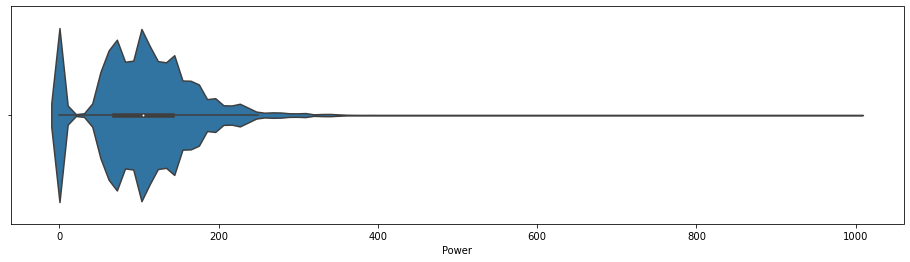

In [21]:
plt.figure(figsize=(16, 4))
sns.violinplot(autos_df.query('Power < 1000')['Power'])

Видны группа околонулевых значений, основная группа серийных автомобилей и длинный хвост примерно от 300 л.с. и выше.  
Посмотрим анкеты с автомобилями с нулевой мощностью.

In [22]:
autos_df.query('Power == 0')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,manual,0,ka,5000,0,petrol,ford,unknown,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,bus,2016,manual,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,small,1990,manual,0,corsa,150000,1,petrol,opel,unknown,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,small,1995,manual,0,unknown,125000,3,petrol,opel,unknown,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,sedan,2005,auto,0,c_klasse,150000,9,petrol,mercedes_benz,unknown,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


Судя по ценам и пробегам, вполне возможно, что данные автомобили продаются на запчасти без двигателя.  
Проверим, какое значение мощности отделяет 99% всех автомобилей от оставшегося 1%.

In [23]:
autos_df['Power'].quantile(0.99)

300.0

Заменим значения мощности больше 300 л.с. на медианные для соответствующего производителя и модели автомобиля.

In [15]:
%%time
autos_df.loc[autos_df['Power'] > 300, 'Power'] = np.nan
fillna_using_filter(df=autos_df, col_to_fill='Power', cols_to_filter=['Model', 'Brand'], fill_with='median')

В столбце "Power" осталось 0 пропущенных значений.
Wall time: 1min 32s


Рассмотрим дату создания анкеты. Скорее всего, как и в случае с датой выгрузки, этот признак не связан с ценой на автомобиль, например, в один и тот же день может быть выложена анкета со старым автомобилем и новым такой же модели, тогда цена будет разная, а дата одна, и наоборот - в разные даты одна и та же модель.

In [26]:
pd.to_datetime(autos_df['DateCreated'], format='%Y-%m-%d %H:%M:%S').dt.year.unique()

array([2016, 2015, 2014], dtype=int64)

То же самое, вероятно, и с датой последнего просмотра.

In [27]:
pd.to_datetime(autos_df['LastSeen'], format='%Y-%m-%d %H:%M:%S').dt.year.unique()

array([2016], dtype=int64)

Таким образом, мы выяснили, что даты наиболее вероятно никак не влияют на цену автомобиля, а значит, не должны быть включены в признаки для обучения.

Теперь осталось проанализировать околонулевые значения цен. Выведем распределения цен меньше 500 евро.

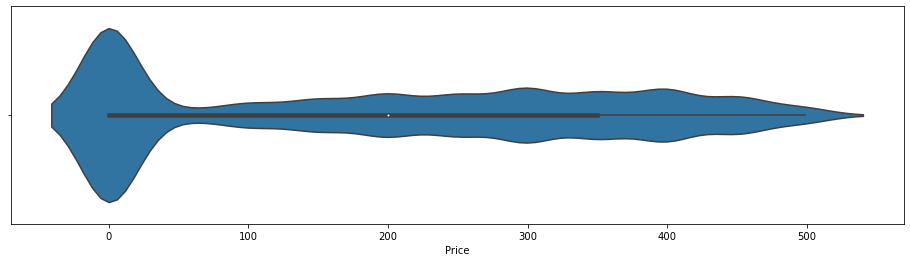

In [28]:
plt.figure(figsize=(16, 4))
sns.violinplot(autos_df.query('Price < 500')['Price'])

In [29]:
autos_df.query('Price < 100')['Price'].count() / len(autos_df) * 100

3.757100649323163

Возможно, есть какая-то логика в анкетах с очень низкими ценами на автомобили, тогда все записи в датафрейме на своих местах, тем более таких анкет около 4%.

In [16]:
# Для ускорения работы на данном шаге выгрузил предобработанный датафрейм.
# autos_df.to_csv('autos_preprocessed.csv', index=False)
# autos_df = pd.read_csv('autos_preprocessed.csv', sep=None, engine='python')

### Вывод

* По итогам анализа признаков было принято решение удалить признаки, содержащие даты, как не связанные с ценой либо вводящие в заблуждение.
* Аномальные значения мощности больше 300 л.с. заменены на медианные для соответствующего производителя и модели автомобиля.
* Аномально низкие значения цены оставлены, так как была предположена реальность таких анкет.

## Отбор признаков

Удалим ненужные столбцы из датафрейма и выведем оставшиеся признаки.

In [17]:
cols_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen']
autos_prepared_df = autos_df.drop(columns=cols_to_drop)
autos_prepared_df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode'],
      dtype='object')

Объединим производителя и модель автомобиля в один признак.

In [18]:
autos_prepared_df['BrandModel'] = autos_prepared_df['Brand'] + ' ' + autos_prepared_df['Model']
autos_prepared_df.drop(columns=['Brand', 'Model'], inplace=True)
autos_prepared_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,NotRepaired,PostalCode,BrandModel
0,480,sedan,1993.0,manual,0.0,150000,petrol,unknown,70435,volkswagen golf
1,18300,coupe,2011.0,manual,190.0,125000,gasoline,yes,66954,audi unknown
2,9800,suv,2004.0,auto,163.0,125000,gasoline,unknown,90480,jeep grand
3,1500,small,2001.0,manual,75.0,150000,petrol,no,91074,volkswagen golf
4,3600,small,2008.0,manual,69.0,90000,gasoline,no,60437,skoda fabia


Запишем в отдельные переменные категориальные и количественные признаки.

In [19]:
categorical_features = autos_prepared_df.dtypes[autos_prepared_df.dtypes == 'object'].index.to_list()
categorical_features

['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'BrandModel']

In [20]:
numeric_features = autos_prepared_df.dtypes[autos_prepared_df.dtypes != 'object'].drop('Price').index.to_list()
numeric_features

['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']

Приведём тип категориальных признаков к типу *'category'*.

In [21]:
autos_prepared_df[categorical_features] = autos_prepared_df[categorical_features].astype('category')
autos_prepared_df.dtypes

Price                  int64
VehicleType         category
RegistrationYear     float64
Gearbox             category
Power                float64
Kilometer              int64
FuelType            category
NotRepaired         category
PostalCode             int64
BrandModel          category
dtype: object

Построим матрицу корреляций количественных признаков для выявления мультиколлинеарности и зависимости целевого признака от регрессоров.

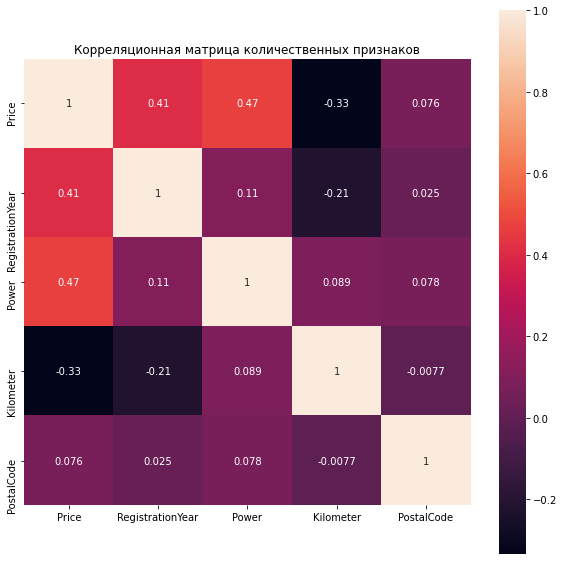

In [22]:
corr_matrix = autos_prepared_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, robust=True, square=True, annot=True)

plt.title('Корреляционная матрица количественных признаков')
plt.show()

Линейной зависимости между регрессорами нет; видна очень слабая связь признака 'PostalCode' и целевого признака.

Построим матрицу рассеяния для проверки наличия или отсутствия нелинейных связей.

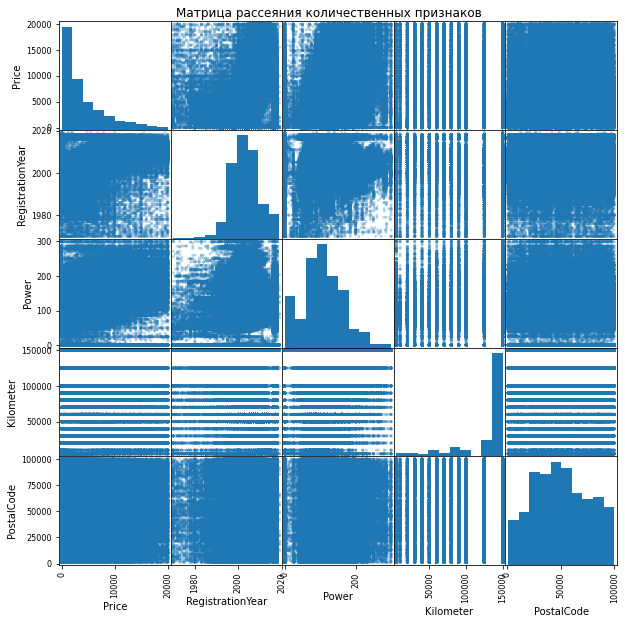

In [23]:
pd.plotting.scatter_matrix(
    autos_prepared_df,
    alpha=0.3,
    figsize=(10, 10)
)

plt.suptitle('Матрица рассеяния количественных признаков', y=0.9);

Видно, что значения почтового индекса почти равномерно распределены по признаку цены, поэтому можно с большой долей уверенности полагать, что связь между ценой и почтовым индеском очень слабая или отсутствует. С другой стороны, визуально определима зависимость между годом регистрации и ценой, а также мощьностью и ценой.

Теперь проверим наличие связей между категориальными признаками. Здесь применим статистику на основе теста $X^2$ - статистику Крамера (V) с коррекцией Бергсмы-Уичера для уменьшения стремления статистики переоценивать силу связи. Она возвращает силу связи между двумя категориальными признаками в диапазоне от 0 до 1, где 0 - зависимость отсутствует, 1 - максимальная зависимость.

In [24]:
def cramers_v(confusion_matrix):
    """
    Вычисляет статистику Крамера (V) для категориально-категориальной связи.
    Использует коррекцию от Бергсмы и Уичера.
    Журнал Корейского Статистического Общества 42 (2013): 323-328.
    
    Аргументы
    ---------
    confusion_matrix : array_like
        Таблица сопряжённости
        
    Возвращает
    ----------
    Значение статистики Крамера (V).
    
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


corr_coefs = []

for col_i in categorical_features:
    corr_coefs_i = []
    
    for col_j in categorical_features:
        
        confusion_matrix = pd.crosstab(index=autos_prepared_df[col_i], columns=autos_prepared_df[col_j])
        corr_coef = cramers_v(confusion_matrix.values)
        
        corr_coefs_i.append(corr_coef)
        
    if corr_coefs_i:
        corr_coefs.append(corr_coefs_i)
    
np.array(corr_coefs)

array([[1.        , 0.21027883, 0.1822984 , 0.07269526, 0.64106151],
       [0.21027883, 0.99999093, 0.16326627, 0.05865326, 0.54857301],
       [0.1822984 , 0.16326627, 1.        , 0.05605903, 0.25919825],
       [0.07269526, 0.05865326, 0.05605903, 1.        , 0.16646043],
       [0.64106151, 0.54857301, 0.25919825, 0.16646043, 1.        ]])

Построим матрицу корреляций на основе посчитанных значений статистики Крамера (V).

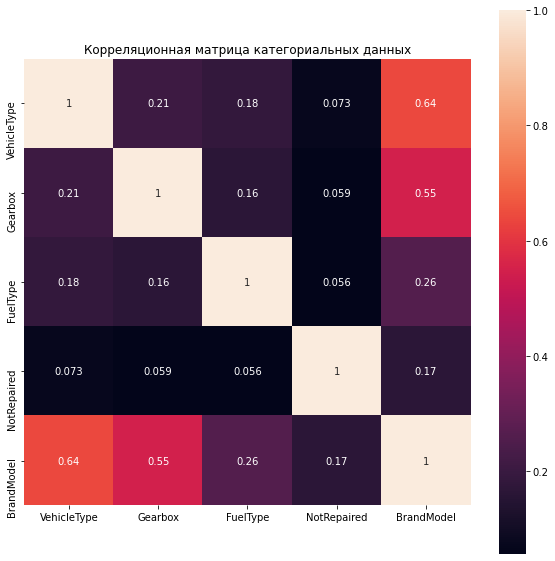

In [25]:
corr_matrix = pd.DataFrame(corr_coefs, index=categorical_features, columns=categorical_features)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, robust=True, square=True, annot=True)

plt.title('Корреляционная матрица категориальных данных')
plt.show()

Как видим, максимальная сила связи 0.64 между принаками **'VehicleType'** и **'BrandModel'**, что не является критичным.

Далее оценим силу связи между категориальными и количественными признаками с помощью одностороннего анализа дисперсий (**oneway ANOVA**). Возвращаемое значение F-статистики говорит о силе связи, а значимость влияет на принятие или отвержение нулевой гипотезы, которая в данном случае звучит так: "Выборки во всех группах взяты из популяций с одинаковыми средними значениями". Если средние значения групп взяты из популяций с одинаковыми средними значениями, то дисперсия между средними значениями групп должна быть ниже дисперсии выборок, следуя центральной предельной теореме. Следовательно, более высокое соотношение означает, что выборки были взяты из популяций с различными средними значениями, что говорит о зависимости между категориальным и количественным признаком.

In [26]:
fvalues = []
pvalues = []
numeric_features_ext = numeric_features + ['Price']

for cat_col in categorical_features:
    fvalues_i = []
    pvalues_i = []
    for num_col in numeric_features_ext:
        series_list = [
            autos_prepared_df[autos_prepared_df[cat_col] == value][num_col]
            for value in autos_prepared_df[cat_col].unique()
        ]
        
        F, pvalue = f_oneway(*series_list)
        
        fvalues_i.append(F)
        pvalues_i.append(pvalue)
        
    fvalues.append(fvalues_i)
    pvalues.append(pvalues_i)
    
fvalues_df = pd.DataFrame(fvalues, index=categorical_features, columns=numeric_features_ext)
pvalues_df = pd.DataFrame(pvalues, index=categorical_features, columns=numeric_features_ext)

Построим тепловые карты с полученными значениями F-статистики и значимости.

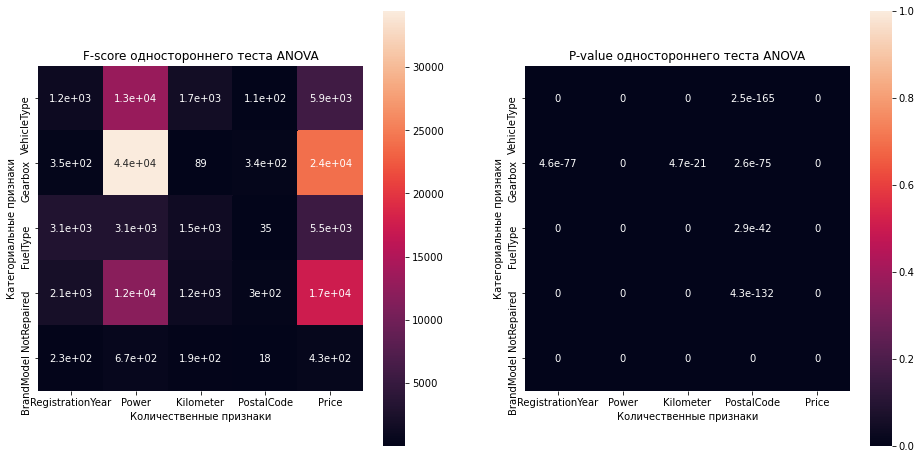

In [27]:
plt.figure(figsize=(16, 8))

plt.subplot(121, title='F-score одностороннего теста ANOVA')
sns.heatmap(fvalues_df, robust=True, square=True, annot=True)
plt.xlabel('Количественные признаки')
plt.ylabel('Категориальные признаки')

plt.subplot(122, title='P-value одностороннего теста ANOVA')
sns.heatmap(pvalues_df, robust=True, square=True, annot=True, vmin=0, vmax=1)
plt.xlabel('Количественные признаки')
plt.ylabel('Категориальные признаки');

Очень низкая значимость для всех пар говорит о том, что нулевая гипотеза отвергается и зависимость между признаками есть. Наиболее сильная связь между признаками **'Gearbox'** и **'Power'**. Недостаток теста заключается в том, что он не позволяет определить границы очень сильной и очень слабой связей. Поэтому придётся оставить все категориальные признаки.

Удалим из датафрейма признак **'PostalCode'** и сформируем множества регрессоров и целевого признака.

In [28]:
features = autos_prepared_df.drop(columns=['Price', 'PostalCode'])
numeric_features.remove('PostalCode')

target = autos_prepared_df['Price']

### Вывод

* По результатам предыдущего раздела были удалены признаки: 'DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen'.
* Признаки производителя и модели автомобиля объединены в один признак.
* Проведён корреляционный анализ количественных признаков, категориальных признаков между собой и связь категориальных признаков с количественными. По итогам анализа был удалён признак 'PostalCode'.

## Обучение моделей

Разделим множества на обучающее и тестовое в соотношении 4:1.

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2,
                                                                            shuffle=True, random_state=RANDOM_STATE)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((283495, 8), (70874, 8), (283495,), (70874,))

Построим бейслайны линейной регрессии и градиентных бустингов из библиотек *LightGBM* и *CatBoost* по следующему алгоритму:
* создадим предобработчик, в котором количественные признаки будут стандартизированы, а категориальные закодированы или оставлены в исходном виде;
* создадим конвейер с предобработчиком и самой моделью;
* число разбиений для кросс-валидации примем равным 5;
* проведём перекрёстную проверку и выведем результаты.

Так как обучающий датасет обязательно должен быть или датафреймом pandas, или датафреймом pool из фреймворка CatBoost, то придётся создать класс-костыль, который преобразует numpy-массив в датафрейм pandas и может быть применён внутри конвейера.

In [32]:
class make_dataframe(BaseEstimator, TransformerMixin):
    """
    Класс предназначен для трансформации входного массива в датафрейм (Pandas.DataFrame).
    Может быть использован в конвейере (Pipeline).
    
    Атрибуты
    --------
    column_names : array-like
        Названия столбцов датафрейма.
    dtypes : array-like
        Типы данных в столбцах.
        
    Методы
    ------
    fit(X, y=None)
        Возвращает экземпляр класса.
    transform(X, y=None)
        Возвращает преобразованный в датафрейм входной массив.
        Для корректного преобразования массив должен быть одно- или двумерным.
    fit_transform(X, y=None)
        Вызывает метод transform().
    """
    
    def __init__(self, column_names, dtypes):
        super().__init__()
        self.column_names = column_names
        self.dtypes = dtypes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        try:
            df = pd.DataFrame(data=X, columns=self.column_names)
        except Exception as e:
            print(e)
            return X
        
        for col, dtype in zip(self.column_names, self.dtypes):
            df[col] = df[col].astype(dtype)
            
        return df
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [78]:
categories = [features[col].unique() for col in categorical_features]

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(categories=categories, drop='first'), categorical_features)
    ],
    n_jobs=-1
)

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(categories=categories), categorical_features)
    ],
    n_jobs=-1
)

preprocessor_3 = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='passthrough',
    n_jobs=-1
)

cols = numeric_features + categorical_features
dtypes_list = features[numeric_features].dtypes.to_list() + features[categorical_features].dtypes.to_list()

pipes_dict = {
    'Линейная регрессия': Pipeline(
        [
            ('preprocessor', preprocessor_1),
            ('lin_reg', LinearRegression(n_jobs=-1))
        ]
    ),
    'Градиентный бустинг LightGBM': Pipeline(
        [
            ('preprocessor', preprocessor_1),
            ('lgb_reg', lgb.LGBMRegressor(random_state=RANDOM_STATE))
        ]
    ),
    'Градиентный бустинг CatBoost': Pipeline(
        [
            ('preprocessor', preprocessor_3),
            ('make_df', make_dataframe(column_names=cols, dtypes=dtypes_list)),
            ('cat_reg', cbt.CatBoostRegressor(n_estimators=100, min_child_samples=20, cat_features=categorical_features,
                                              random_state=RANDOM_STATE, verbose=False))
        ]
    )
}

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores_list = [
    cross_val_score(
        estimator=pipe,
        X=features_train,
        y=target_train,
        scoring=NEG_RMSE,
        cv=kfold,
        n_jobs=-1
    )
    for pipe in pipes_dict.values()
]
        
rmse_mean_list = [-cv_scores.mean() for cv_scores in cv_scores_list]
for desc, rmse in zip(pipes_dict.keys(), rmse_mean_list):
    print('{}, RMSE = {:.2f}'.format(desc, rmse))

Линейная регрессия, RMSE = 2832.48
Градиентный бустинг LightGBM, RMSE = 1950.20
Градиентный бустинг CatBoost, RMSE = 1980.78


Примерно на одном уровне качество градиентных бустингов и лучше почти на треть, чем качество линейной регрессии.

Подберём гиперпараметры, чтобы улучщить качество моделей, а также измерим время выполнения. Перебирать будем по случайной сетке, что должно уменьшить время подбора гиперпараметров.

In [70]:
%%time
cv_params = {
    'lgb_reg__n_estimators': [200],
    'lgb_reg__max_depth': range(5, 13, 2),
    'lgb_reg__num_leaves': range(30, 120, 20),
    'lgb_reg__min_child_samples': range(20, 100, 20)
}

lgb_cv = RandomizedSearchCV(
    estimator=pipes_dict['Градиентный бустинг LightGBM'],
    param_distributions=cv_params,
    n_iter=20,
    scoring=NEG_RMSE,
    n_jobs=-1,
    cv=kfold,
    random_state=RANDOM_STATE,
    return_train_score=True
)

lgb_cv.fit(features_train, target_train)

Wall time: 7min 31s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer']),
                                                                              ('cat',
                                                                               OneHotEncoder(categories=[[sedan, coupe, suv, small, convertible, bus, wagon, other]
Categories (8, object): [sedan, coupe, suv, small, con...
                

Выведем лучшие гиперпараметры.

In [71]:
lgb_cv.best_params_

{'lgb_reg__num_leaves': 90,
 'lgb_reg__n_estimators': 200,
 'lgb_reg__min_child_samples': 20,
 'lgb_reg__max_depth': 11}

Выведем результат на кросс-валидации.

In [72]:
-lgb_cv.best_score_

1854.0354774182756

Как видно, качество модели выросло почти на 5%.  
Выведем результаты при соответствующих гиперпараметрах на тренировочной выборке.

In [73]:
-lgb_cv.cv_results_['mean_train_score'][lgb_cv.cv_results_['mean_test_score'] == lgb_cv.best_score_][0]

1786.9932898851598

Разница с валидацией составляет около -4%, что говорит о небольшом переобучении, но является приемлемым значением.

Повторим действия с градиентным бустингом из фреймворка CatBoost. Сетку значений используем ту же, с добавлением политики роста ('Depthwise' и 'Lossguide'), так как политика роста деревьев 'SymmetricTree' не позволяет работать с некоторыми значениями и гиперпараметрами.

In [81]:
%%time
cv_params = {
    'cat_reg__n_estimators': [200],
    'cat_reg__grow_policy': ['Depthwise', 'Lossguide'],
    'cat_reg__max_depth': range(5, 13, 2),
    'cat_reg__num_leaves': range(30, 120, 20),
    'cat_reg__min_child_samples': range(20, 100, 20)
}

cbt_cv = RandomizedSearchCV(
    estimator=pipes_dict['Градиентный бустинг CatBoost'],
    param_distributions=cv_params,
    n_iter=10,
    scoring=NEG_RMSE,
    n_jobs=-1,
    cv=kfold,
    random_state=RANDOM_STATE,
    return_train_score=True
)

cbt_cv.fit(features_train, target_train)

Wall time: 16min 59s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer'])])),
                                             ('make_df',
                                              make_dataframe(column_names=['RegistrationYear',
                                                                           'Powe

Выведем лучшие гиперпараметры.

In [82]:
cbt_cv.best_params_

{'cat_reg__num_leaves': 90,
 'cat_reg__n_estimators': 200,
 'cat_reg__min_child_samples': 60,
 'cat_reg__max_depth': 11,
 'cat_reg__grow_policy': 'Lossguide'}

Выведем результат на кросс-валидации.

In [83]:
-cbt_cv.best_score_

1883.691808575474

Как видно, качество модели выросло почти на 4.9%.  
Выведем результаты при соответствующих гиперпараметрах на тренировочной выборке.

In [84]:
-cbt_cv.cv_results_['mean_train_score'][cbt_cv.cv_results_['mean_test_score'] == cbt_cv.best_score_][0]

1701.20864418652

Разница с валидацией составляет около -9.6%, что говорит о небольшом переобучении, но является приемлемым значением.

### Вывод

* Выбраны модели линейной регрессии и градиентного бустинга из двух библиотек: CatBoost и LightGBM.
* Модели были обучены с настройками по умолчанию. Измерено качество с помощью кросс-валидации:
    * Линейная регрессия, RMSE = 2832.48
    * Градиентный бустинг LightGBM, RMSE = 1950.20
    * Градиентный бустинг CatBoost, RMSE = 1980.78
* Проведён подбор гиперпараметров с помощью поиска по случайной сетке.
* Лучшие гиперпараметры:
    * Градиентный бустинг LightGBM:
        * максимальное число листьев: 90,
        * число деревьев: 200,
        * минимальное число объектов на листе: 20,
        * максимальная глубина дерева: 11.
     * Градиентный бустинг CatBoost:
        * максимальное число листьев: 90,
        * число деревьев: 200,
        * минимальное число объектов на листе: 60,
        * максимальная глубина дерева: 11,
        * политика роста дерева: "лист за листом".
* Качество моделей после настройки:
    * градиентный бустинг LightGBM, RMSE = 1854.04 (**-4.9**%)
    * градиентный бустинг CatBoost, RMSE = 1883.69 (**-4.9**%)

## Анализ моделей

Проанализируем время обучения и прогнозирования моделей.

In [91]:
pipes_dict['Градиентный бустинг LightGBM'].steps[-1]

('lgb_reg', LGBMRegressor(random_state=17))

In [96]:
%%time
params = {
    'lgb_reg__n_estimators': 200,
    'lgb_reg__max_depth': 11,
    'lgb_reg__num_leaves': 90,
    'lgb_reg__min_child_samples': 20
}

lgb_pipe = pipes_dict['Градиентный бустинг LightGBM'].set_params(**params)

lgb_pipe.fit(features_train, target_train)

Wall time: 3.72 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[[sedan, coupe, suv, small, convertible, bus, wagon, other]
Categories (8, object): [sedan, coupe, suv, small, convertible, bus, wagon, other],
                                                                            [manual, auto]
Categories (2, object): [manual, auto],
                                                                            [petr...
                                                                            [volkswagen golf, audi unknown, jeep grand, skoda fabia, bmw 3er, ..., lancia kappa, rover freelander, land_rover serie_3, land_rove

In [97]:
%%time
predictions = lgb_pipe.predict(features_test)
lgb_rmse = mean_squared_error(target_test, predictions, squared=False)
print('Градиентный бустинг LightGBM, RMSE = {:.3f}'.format(lgb_rmse))

Градиентный бустинг LightGBM, RMSE = 1831.716
Wall time: 971 ms


In [101]:
%%time
params = {
    'cat_reg__n_estimators': 200,
    'cat_reg__max_depth': 11,
    'cat_reg__num_leaves': 90,
    'cat_reg__min_child_samples': 60,
    'cat_reg__grow_policy': 'Lossguide'
}

cat_pipe = pipes_dict['Градиентный бустинг CatBoost'].set_params(**params)

cat_pipe.fit(features_train, target_train)

Wall time: 1min 1s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('make_df',
                 make_dataframe(column_names=['RegistrationYear', 'Power',
                                              'Kilometer', 'VehicleType',
                                              'Gearbox', 'FuelType',
                                              'NotRepaired', 'BrandModel'],
                                dtypes=[dtype('float64'), dtype('float64')...
                                        CategoricalDtype(categories=['alfa_romeo 145', 'alfa_romeo 147', 'alfa_romeo 156',
                  'alfa_romeo 159', 'alfa_romeo other', 'alfa_romeo spider',
                  'alfa_romeo unknown', 'audi 100', 'audi 200', 'audi 80

In [103]:
%%time
predictions = cat_pipe.predict(features_test)
cat_rmse = mean_squared_error(target_test, predictions, squared=False)
print('Градиентный бустинг CatBoost, RMSE = {:.3f}'.format(cat_rmse))

Градиентный бустинг CatBoost, RMSE = 1856.389
Wall time: 586 ms


In [104]:
%%time
lin_pipe = pipes_dict['Линейная регрессия']

lin_pipe.fit(features_train, target_train)

Wall time: 7.62 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[[sedan, coupe, suv, small, convertible, bus, wagon, other]
Categories (8, object): [sedan, coupe, suv, small, convertible, bus, wagon, other],
                                                                            [manual, auto]
Categories (2, object): [manual, auto],
                                                                            [petr...
                                                                            [volkswagen golf, audi unknown, jeep grand, skoda fabia, bmw 3er, ..., lancia kappa, rover freelander, land_rover serie_3, land_rove

In [105]:
%%time
predictions = lin_pipe.predict(features_test)
lin_rmse = mean_squared_error(target_test, predictions, squared=False)
print('Линейная регрессия, RMSE = {:.3f}'.format(lin_rmse))

Линейная регрессия, RMSE = 2829.405
Wall time: 1.17 s


Таким образом, быстрее всех из выбранных моделей обучается бустинг LightGBM, прогнозирует - бустинг CatBoost (однако "горячее" кодирование серьёзно влияет на время процессов). CatBoostRegressor обучается больше минуты, но почти в два раза быстрее LightGBM строит прогноз. Прогноз модели строят за время порядка 1 секунды.

Проверим дополнительно полученные модели на адекватность: обучим фиктивную модель регрессии по двум стратегиям (среднее и медиана).

In [106]:
strategy = ['mean', 'median']
dum_pipes = [Pipeline([('preprocessor', preprocessor_1), ('dum_reg', DummyRegressor(strategy=s))]) for s in strategy]

[dum_pipe.fit(features_train, target_train) for dum_pipe in dum_pipes]

predictions_list = [dum_pipe.predict(features_test) for dum_pipe in dum_pipes]
dum_rmse_list = [mean_squared_error(target_test, predictions, squared=False) for predictions in predictions_list]

Построим график, чтобы понять наверняка: адекватны ли модели или нет.

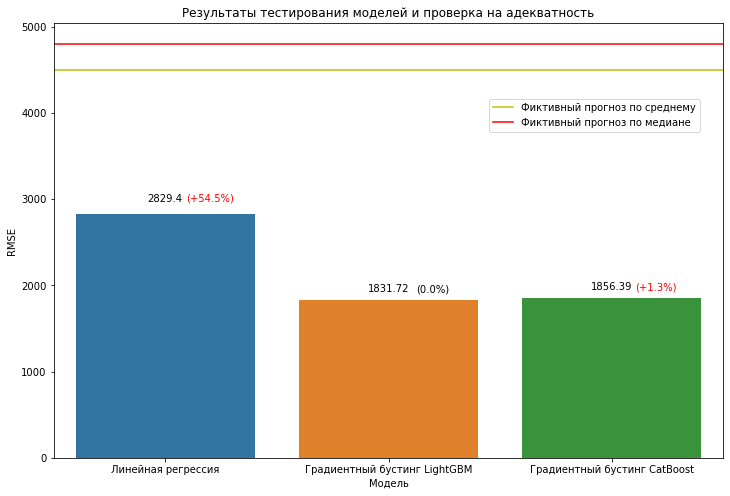

In [111]:
rmse_array = np.array([lin_rmse, lgb_rmse, cat_rmse])
best_rmse = rmse_array.min()
diff_array = (rmse_array - best_rmse) / best_rmse * 100

score_df = pd.DataFrame(
    {'model': [desc for desc in pipes_dict],
     'rmse': rmse_array,
     'difference': diff_array
    }
)

plt.figure(figsize=(12, 8))
g = sns.barplot(x='model', y='rmse', data=score_df)
plt.axhline(y=dum_rmse_list[0], color='y', linestyle='-', label='Фиктивный прогноз по среднему')
plt.axhline(y=dum_rmse_list[1], color='r', linestyle='-', label='Фиктивный прогноз по медиане')

for index, row in score_df.iterrows():
    g.text(x=index, y=row.rmse * 1.05, s=round(row.rmse, 2), color='black', ha='center')
    if row.difference > 0:
        clr='red'
        prefix = '+'
    else:
        clr='black'
        prefix = ''
    g.text(x=index+0.2, y=row.rmse * 1.05, s='(' + prefix + str(round(row.difference, 1)) + '%)', color=clr, ha='center')

plt.legend(loc=(0.65, 0.75))
plt.title('Результаты тестирования моделей и проверка на адекватность')
plt.xlabel('Модель')
plt.ylabel('RMSE');

Видно, что все модели показали адекватный результат, лучший результат у модели градиентного бустинга из библиотеки LightGBM.

### Вывод

* Результаты измерения времени обучения моделей:
    * линейная регрессия - 7.62 с
    * градиентный бустинг LightGBM - 3.72 с
    * градиентный бустинг CatBoost - 1 мин 1 с
* Результаты измерения времени вычисления прогноза моделей:
    * линейная регрессия - 1.17 с
    * градиентный бустинг LightGBM - 971 мс
    * градиентный бустинг CatBoost - 586 мс
* Наиболее быстрая модель - линейная регрессия, но она не самая точная.
* Результаты тестирования моделей:
    * линейная регрессия, RMSE = 2829.4
    * градиентный бустинг LightGBM, RMSE = 1831.72
    * градиентный бустинг CatBoost, RMSE = 1856.39
* Все модели успешно прошли проверку на адекватность.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей